In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math
import pandas as pd

%matplotlib inline

In [2]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368

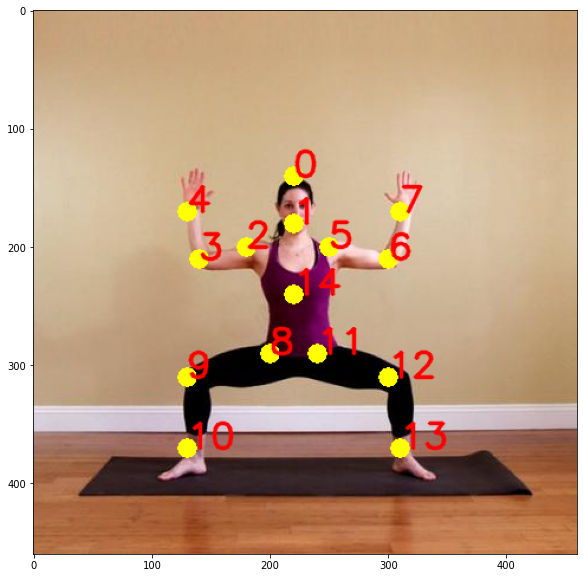

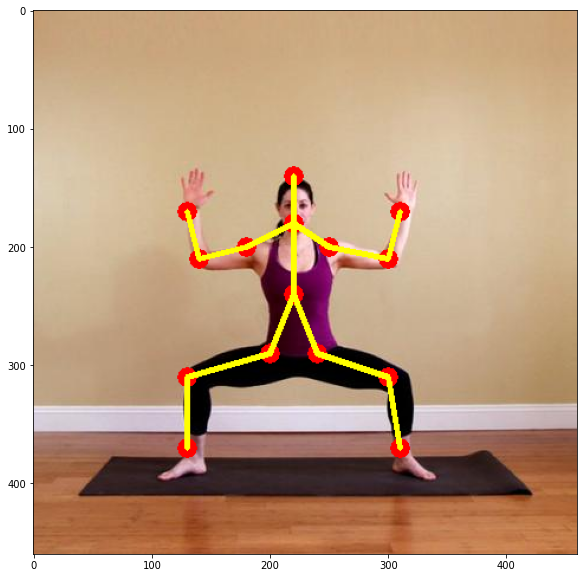

In [4]:
pose_coordinates = []
img = 'DATASET/TRAIN/goddess/00000104.jpeg'
frame = cv2.imread(img)
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                      (0, 0, 0), swapRB=False, crop=False)
net.setInput(inpBlob)
output = net.forward()
H = output.shape[2]
W = output.shape[3]
points = []
for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H
    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            
        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)
        
pose_coordinates.append(points)
    # Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [6]:
f = open("../AngleValues/poseIndices.json")
pose_indices_dict = json.load(f)
f.close()

In [7]:
def calculate_angle(indices, coordinates):
    p1 = coordinates[indices[0]]
    p2 = coordinates[indices[1]]
    p3 = coordinates[indices[2]]
    
    if p1 and p2 and p3:

        if(p3[0] - p2[0] == 0 and p2[0] - p1[0] == 0):
            return 0
        if(p2[0] - p1[0] == 0):
            m2 = (p3[1] - p2[1])/(p3[0] - p2[0])
            return (90 - math.degrees(math.atan(m2)))
        if(p3[0] - p2[0] == 0):
            m1 = (p2[1] - p1[1])/(p2[0] - p1[0])
            return (90 - math.degrees(math.atan(m1)))
        m1 = (p2[1] - p1[1])/(p2[0] - p1[0])
        m2 = (p3[1] - p2[1])/(p3[0] - p2[0])
        if(m1 * m2 == -1):
            theta = 90
        else:
            tan_theta = (m2-m1)/(1 + m1 * m2)
            theta = math.degrees(math.atan(tan_theta))
            #if abs(theta) > 90:
                #theta = 180 - abs(theta)
        return theta
    else:
        return 1000

In [8]:
train_angles = []
test_angles = []
for coordinates in pose_coordinates:
    angles = []
    for joint in pose_indices_dict:
        angle = calculate_angle(pose_indices_dict[joint], coordinates)
        angles.append(angle)
    train_angles.append(angles)
    print(len(train_angles))

1


In [9]:
train_angles

[[90,
  -87.27368900609373,
  105.94539590092285,
  62.10272896905237,
  116.56505117707799,
  56.309932474020215,
  52.25319461272534,
  -49.76364169072618,
  0]]

In [10]:
pose_indices_dict

{'elbow-l': [2, 3, 4],
 'elbow-r': [5, 6, 7],
 'knee-l': [8, 9, 10],
 'knee-r': [11, 12, 13],
 'kneck-l': [0, 1, 2],
 'kneck-r': [0, 1, 5],
 'leg-l': [14, 8, 9],
 'leg-r': [14, 11, 12],
 'back': [0, 1, 14]}

In [5]:
pose_coordinates

[[(220, 140),
  (220, 180),
  (180, 200),
  (140, 210),
  (130, 170),
  (250, 200),
  (300, 210),
  (310, 170),
  (200, 290),
  (130, 310),
  (130, 370),
  (240, 290),
  (300, 310),
  (310, 370),
  (220, 240)]]

In [17]:
dataset = 'DATASET'
os.listdir(dataset)

['TEST', 'TRAIN']

In [18]:
train_set = os.path.join(dataset, 'TRAIN')
test_set = os.path.join(dataset, 'TEST')
print(train_set, test_set)

DATASET\TRAIN DATASET\TEST


In [21]:
train_img_paths = []
for path in os.listdir(train_set):
    train_img_paths.append(os.path.join(train_set, path))
train_img_paths

['DATASET\\TRAIN\\goddess',
 'DATASET\\TRAIN\\halfMoon',
 'DATASET\\TRAIN\\tree',
 'DATASET\\TRAIN\\triangle',
 'DATASET\\TRAIN\\warrior2']

In [22]:
test_img_paths = []
for path in os.listdir(test_set):
    test_img_paths.append(os.path.join(test_set, path))
test_img_paths

['DATASET\\TEST\\goddess',
 'DATASET\\TEST\\halfMoon',
 'DATASET\\TEST\\tree',
 'DATASET\\TEST\\triangle',
 'DATASET\\TEST\\warrior2']

In [40]:
counter = 1
train_image_names = []
train_pose_coordinates = []
train_target_poses = []
pose_coordinates = []
for path in train_img_paths:
    images = os.listdir(path)
    for image in images:
        train_image_names.append(image)
        train_target_poses.append(path.split('\\')[2])
        img = os.path.join(path, image)
        frame = cv2.imread(img)
        frameCopy = np.copy(frame)
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]
        threshold = 0.1
        inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                      (0, 0, 0), swapRB=False, crop=False)
        net.setInput(inpBlob)
        output = net.forward()
        H = output.shape[2]
        W = output.shape[3]
        points = []
        for i in range(nPoints):
            # confidence map of corresponding body's part.
            probMap = output[0, i, :, :]

            # Find global maxima of the probMap.
            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
            # Scale the point to fit on the original image
            x = (frameWidth * point[0]) / W
            y = (frameHeight * point[1]) / H
            if prob > threshold : 
                #cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                #cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
                #cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            
                # Add the point to the list if the probability is greater than the threshold
                points.append((int(x), int(y)))
            else :
                points.append(None)
        
        pose_coordinates.append(points)
        print(counter, len(pose_coordinates))
        counter = counter + 1

1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81
82 82
83 83
84 84
85 85
86 86
87 87
88 88
89 89
90 90
91 91
92 92
93 93
94 94
95 95
96 96
97 97
98 98
99 99
100 100
101 101
102 102
103 103
104 104
105 105
106 106
107 107
108 108
109 109
110 110
111 111
112 112
113 113
114 114
115 115
116 116
117 117
118 118
119 119
120 120
121 121
122 122
123 123
124 124
125 125
126 126
127 127
128 128
129 129
130 130
131 131
132 132
133 133
134 134
135 135
136 136
137 137
138 138
139 139
140 140
141 141
142 142
143 143
144 144
145 145
146 146
147 147
148 148
149 149
150 150
151 151
152 152


1042 1042
1043 1043
1044 1044
1045 1045
1046 1046
1047 1047
1048 1048
1049 1049
1050 1050
1051 1051
1052 1052
1053 1053
1054 1054
1055 1055
1056 1056
1057 1057
1058 1058
1059 1059
1060 1060
1061 1061
1062 1062
1063 1063
1064 1064
1065 1065
1066 1066
1067 1067
1068 1068
1069 1069
1070 1070
1071 1071
1072 1072
1073 1073
1074 1074


In [41]:
counter = 1
test_image_names = []
test_pose_coordinates = []
test_target_poses = []
test_pose_coordinates = []
for path in test_img_paths:
    images = os.listdir(path)
    for image in images:
        test_image_names.append(image)
        test_target_poses.append(path.split('\\')[2])
        img = os.path.join(path, image)
        frame = cv2.imread(img)
        frameCopy = np.copy(frame)
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]
        threshold = 0.1
        inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                      (0, 0, 0), swapRB=False, crop=False)
        net.setInput(inpBlob)
        output = net.forward()
        H = output.shape[2]
        W = output.shape[3]
        points = []
        for i in range(nPoints):
            # confidence map of corresponding body's part.
            probMap = output[0, i, :, :]

            # Find global maxima of the probMap.
            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
            # Scale the point to fit on the original image
            x = (frameWidth * point[0]) / W
            y = (frameHeight * point[1]) / H
            if prob > threshold : 
                #cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                #cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
                #cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            
                # Add the point to the list if the probability is greater than the threshold
                points.append((int(x), int(y)))
            else :
                points.append(None)
        
        test_pose_coordinates.append(points)
        print(counter, len(test_pose_coordinates))
        counter = counter + 1

1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81
82 82
83 83
84 84
85 85
86 86
87 87
88 88
89 89
90 90
91 91
92 92
93 93
94 94
95 95
96 96
97 97
98 98
99 99
100 100
101 101
102 102
103 103
104 104
105 105
106 106
107 107
108 108
109 109
110 110
111 111
112 112
113 113
114 114
115 115
116 116
117 117
118 118
119 119
120 120
121 121
122 122
123 123
124 124
125 125
126 126
127 127
128 128
129 129
130 130
131 131
132 132
133 133
134 134
135 135
136 136
137 137
138 138
139 139
140 140
141 141
142 142
143 143
144 144
145 145
146 146
147 147
148 148
149 149
150 150
151 151
152 152


In [51]:
f = open("../AngleValues/angles.json")
angle_dict = json.load(f)

In [52]:
print(angle_dict)

{'Goddess': {'elbow-l': 90, 'elbow-r': -87.27368900609373, 'knee-l': 74.05460409907715, 'knee-r': 62.10272896905237, 'kneck-l': 63.43494882292201, 'kneck-r': 56.309932474020215, 'leg-l': 52.25319461272534, 'leg-r': -49.76364169072618, 'back': 0}, 'Half Moon': {'elbow-l': 0, 'elbow-r': 15.037815903582242, 'knee-l': -13.30066214553753, 'knee-r': 10.162083194000758, 'kneck-l': 60.65168013073499, 'kneck-r': -73.98941022747586, 'leg-l': 6.620776082314977, 'leg-r': -79.83791680599924, 'back': 0.7493188328838571}, 'Tree': {'elbow-l': 38.24748654569379, 'elbow-r': -9.673355432403495, 'knee-l': 33.52447324857696, 'knee-r': 10.66034829453531, 'kneck-l': 71.83404347077447, 'kneck-r': 71.83404347077447, 'leg-l': 39.82542125282, 'leg-r': 14.036243467926468, 'back': 7.125016348901795}, 'Triangle': {'elbow-l': 0, 'elbow-r': 0, 'knee-l': 11.82784631788973, 'knee-r': -7.271816160531724, 'kneck-l': 84.17365797044422, 'kneck-r': 84.17365797044422, 'leg-l': -80.71600916784341, 'leg-r': 68.47210396943811, 

In [53]:
f = open("../AngleValues/poseIndices.json")
pose_indices_dict = json.load(f)
f.close()

In [54]:
print(pose_indices_dict)

{'elbow-l': [2, 3, 4], 'elbow-r': [5, 6, 7], 'knee-l': [8, 9, 10], 'knee-r': [11, 12, 13], 'kneck-l': [0, 1, 2], 'kneck-r': [0, 1, 5], 'leg-l': [14, 8, 9], 'leg-r': [14, 11, 12], 'back': [0, 1, 14]}


In [63]:
def calculate_angle(indices, coordinates):
    p1 = coordinates[indices[0]]
    p2 = coordinates[indices[1]]
    p3 = coordinates[indices[2]]
    
    if p1 and p2 and p3:

        if(p3[0] - p2[0] == 0 and p2[0] - p1[0] == 0):
            return 0
        if(p2[0] - p1[0] == 0):
            m2 = (p3[1] - p2[1])/(p3[0] - p2[0])
            return (90 - math.degrees(math.atan(m2)))
        if(p3[0] - p2[0] == 0):
            m1 = (p2[1] - p1[1])/(p2[0] - p1[0])
            return (90 - math.degrees(math.atan(m1)))
        m1 = (p2[1] - p1[1])/(p2[0] - p1[0])
        m2 = (p3[1] - p2[1])/(p3[0] - p2[0])
        if(m1 * m2 == -1):
            theta = 90
        else:
            tan_theta = (m2-m1)/(1 + m1 * m2)
            theta = math.degrees(math.atan(tan_theta))
            #if abs(theta) > 90:
                #theta = 180 - abs(theta)
        return theta
    else:
        return 1000

In [64]:
train_angles = []
test_angles = []
for coordinates in pose_coordinates:
    angles = []
    for joint in pose_indices_dict:
        angle = calculate_angle(pose_indices_dict[joint], coordinates)
        angles.append(angle)
    train_angles.append(angles)
    print(len(train_angles))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [66]:
for coordinates in test_pose_coordinates:
    angles = []
    for joint in pose_indices_dict:
        angle = calculate_angle(pose_indices_dict[joint], coordinates)
        angles.append(angle)
    test_angles.append(angles)
    print(len(test_angles))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [70]:
# train_image_names, train_target_poses, pose_coordinates and train_angles
# test_image_names, test_target_poses, test_coordinates and test_angles

In [71]:
column_names = []
for joint in pose_indices_dict:
    column_names.append(joint)
print(column_names)

['elbow-l', 'elbow-r', 'knee-l', 'knee-r', 'kneck-l', 'kneck-r', 'leg-l', 'leg-r', 'back']


In [74]:
train_angles_df = pd.DataFrame(train_angles, columns = column_names)
train_angles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074 entries, 0 to 1073
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   elbow-l  1074 non-null   float64
 1   elbow-r  1074 non-null   float64
 2   knee-l   1074 non-null   float64
 3   knee-r   1074 non-null   float64
 4   kneck-l  1074 non-null   float64
 5   kneck-r  1074 non-null   float64
 6   leg-l    1074 non-null   float64
 7   leg-r    1074 non-null   float64
 8   back     1074 non-null   float64
dtypes: float64(9)
memory usage: 75.6 KB


In [76]:
train_targets_df = pd.DataFrame(train_target_poses, columns = ['Pose'])
train_targets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074 entries, 0 to 1073
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Pose    1074 non-null   object
dtypes: object(1)
memory usage: 8.5+ KB


In [77]:
train_df = pd.concat([train_angles_df, train_targets_df], axis = 1, join = 'inner')
train_df.head()

,elbow-l,elbow-r,knee-l,knee-r,kneck-l,kneck-r,leg-l,leg-r,back,Pose
0,56.221785,-56.221785,119.981639,65.224859,63.434949,-34.954670,27.457923,-33.157468,14.036243,goddess
1,151.557071,-71.760599,80.551799,58.762975,72.534825,-42.226689,101.888658,-35.793341,15.154068,goddess
2,45.000000,66.889557,86.744133,74.248826,54.741300,84.375656,-50.131165,-21.221589,-9.667596,goddess
3,134.838604,32.916718,83.896048,-89.613442,123.490779,56.706437,46.518720,-40.801327,0.000000,goddess
4,79.837615,-71.221967,-66.804016,76.452061,111.801409,68.198591,47.641267,-46.913279,0.000000,goddess


In [78]:
train_df.to_csv('train_openpose.csv')

In [79]:
test_angles_df = pd.DataFrame(test_angles, columns = column_names)
test_targets_df = pd.DataFrame(test_target_poses, columns = ['Pose'])
test_df = pd.concat([test_angles_df, test_targets_df], axis = 1, join = 'inner')
test_df.head()

,elbow-l,elbow-r,knee-l,knee-r,kneck-l,kneck-r,leg-l,leg-r,back,Pose
0,-89.508278,89.406604,113.242903,55.356604,108.178019,76.115332,39.935116,-37.127985,9.323592,goddess
1,-10.670643,36.869898,113.875281,66.124719,112.750976,73.886582,44.323310,-29.254822,0.000000,goddess
2,70.749015,-64.653824,101.987512,78.012488,110.256462,60.478638,53.936990,-53.936990,0.000000,goddess
3,64.904699,87.276959,81.947289,99.357895,75.888466,108.693036,-67.759670,43.669342,9.531646,goddess
4,-78.163973,69.585330,-57.464518,65.759738,90.000000,102.633362,39.643429,-60.015224,0.000000,goddess


In [80]:
test_df.to_csv('test_openpose.csv')